**STEP 1 – Mount Google Drive & Define Project Paths**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install keras-tcn --quiet


Mounted at /content/drive


In [2]:
import os

# Base project folder
BASE = "/content/drive/My Drive/GoldForecasting_Project (ISY5002)"
DATA = os.path.join(BASE, "Data")
MODELS = os.path.join(BASE, "Models", "TCN")
OUT = os.path.join(BASE, "Outputs")

print("Paths set:")
print("DATA:", DATA)
print("MODELS:", MODELS)
print("OUTPUTS:", OUT)


Paths set:
DATA: /content/drive/My Drive/GoldForecasting_Project (ISY5002)/Data
MODELS: /content/drive/My Drive/GoldForecasting_Project (ISY5002)/Models/TCN
OUTPUTS: /content/drive/My Drive/GoldForecasting_Project (ISY5002)/Outputs


**STEP 2 – Import Libraries**

In [21]:
# STEP 2 – Import Libraries & Set Random Seed

# -------------------------
# Library Imports
# -------------------------
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tcn import TCN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf

# -------------------------
# Set Random Seed for Reproducibility
# -------------------------
SEED = 99  # You can choose any integer, e.g., 7, 99, 1234
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print(f"✅ Random seed fixed at {SEED} for reproducibility.")


✅ Random seed fixed at 99 for reproducibility.


**STEP 3 – Load and Preprocess Dataset**

In [22]:
file_path = os.path.join(DATA, "XAU_USD Historical Price Data_2021-2025.csv")
df = pd.read_csv(file_path)


# Preprocess date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Rename Price → Close
df.rename(columns={'Price': 'Close'}, inplace=True)

# Drop Vol. if exists
if 'Vol.' in df.columns:
    df.drop(columns=['Vol.'], inplace=True)

# Clean Change column
df['Change'] = df['Change %'].str.replace('%', '').astype(float)

print(df.head())


           Date     Close      Open      High       Low Change %  Change
1198 2021-01-01  1,898.10  1,897.69  1,899.12  1,897.39    0.09%    0.09
1197 2021-01-04  1,942.28  1,906.05  1,944.65  1,905.36    2.33%    2.33
1196 2021-01-05  1,949.35  1,942.65  1,953.17  1,934.08    0.36%    0.36
1195 2021-01-06  1,918.81  1,950.30  1,959.60  1,901.11   -1.57%   -1.57
1194 2021-01-07  1,912.50  1,919.40  1,927.97  1,906.86   -0.33%   -0.33


**STEP 4 – Select Features**

In [23]:
features = ['Open', 'High', 'Low', 'Close', 'Change']
target = 'Close'   # You are forecasting Close prices

# Clean numeric columns (remove commas)
for col in features:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

**STEP 5 – Normalize Features**

In [24]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])


**STEP 6 – Create Sequences**

In [25]:
X, y = [], []
sequence_length = 20

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i][features.index(target)])

X = np.array(X)
y = np.array(y)


**Step 7 – Train/Validation/Test Split (70/15/15)**

In [26]:
# STEP 7 – Train/Validation/Test Split (70/15/15) with SEED Reference

# Ensure reproducibility
print(f"Using SEED = {SEED} for dataset split consistency")

total_samples = len(X)

# Define split ratios
train_ratio = 0.70
val_ratio   = 0.15
test_ratio  = 0.15  # (implicitly = 1 - train - val)

# Compute sizes
train_size = int(total_samples * train_ratio)
val_size   = int(total_samples * val_ratio)
test_size  = total_samples - train_size - val_size

# Sequential split (no shuffle — important for time series)
X_train, y_train = X[:train_size], y[:train_size]
X_val,   y_val   = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test,  y_test  = X[train_size + val_size:], y[train_size + val_size:]

# Display summary
print("Train:", X_train.shape, y_train.shape)
print("Validate:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Using SEED = 99 for dataset split consistency
Train: (825, 20, 5) (825,)
Validate: (176, 20, 5) (176,)
Test: (178, 20, 5) (178,)


**Step 7a – Show Train/Validation/Test Periods**

In [27]:
# Align dates for each split
dates = df['Date'].iloc[sequence_length:].reset_index(drop=True)

train_dates = dates[:len(X_train)]
val_dates   = dates[len(X_train):len(X_train)+len(X_val)]
test_dates  = dates[len(X_train)+len(X_val):]

print("Train period: ", train_dates.min().date(), " → ", train_dates.max().date())
print("Validation period: ", val_dates.min().date(), " → ", val_dates.max().date())
print("Test period: ", test_dates.min().date(), " → ", test_dates.max().date())


Train period:  2021-01-29  →  2024-04-01
Validation period:  2024-04-02  →  2024-12-03
Test period:  2024-12-04  →  2025-08-11


**Step 8 – Visualize One Training Sequence**

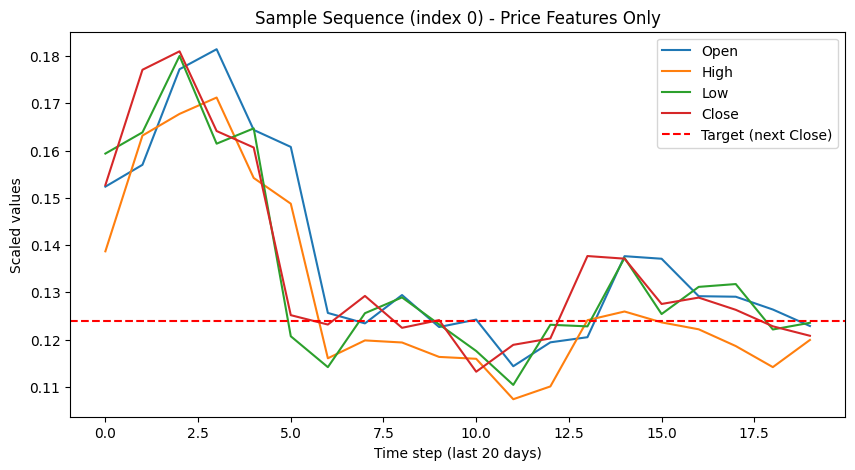

In [28]:
# Step 8 – Visualize One Training Sequence
import matplotlib.pyplot as plt
import pandas as pd

# Pick one sample (e.g., the first training sequence)
sample_index = 0
sequence = X_train[sample_index]   # shape (20, 5)
target_value = y_train[sample_index]

# Convert to DataFrame for easier plotting
seq_df = pd.DataFrame(sequence, columns=features)

# Plot only Price Features (exclude Change)
plt.figure(figsize=(10,5))
for col in ['Open','High','Low','Close']:
    plt.plot(seq_df.index, seq_df[col], label=col)

plt.axhline(target_value, color="red", linestyle="--", label="Target (next Close)")
plt.title(f"Sample Sequence (index {sample_index}) - Price Features Only")
plt.xlabel("Time step (last 20 days)")
plt.ylabel("Scaled values")
plt.legend()
plt.show()


**Step 9 – Visualize Train/Validation/Test Split**

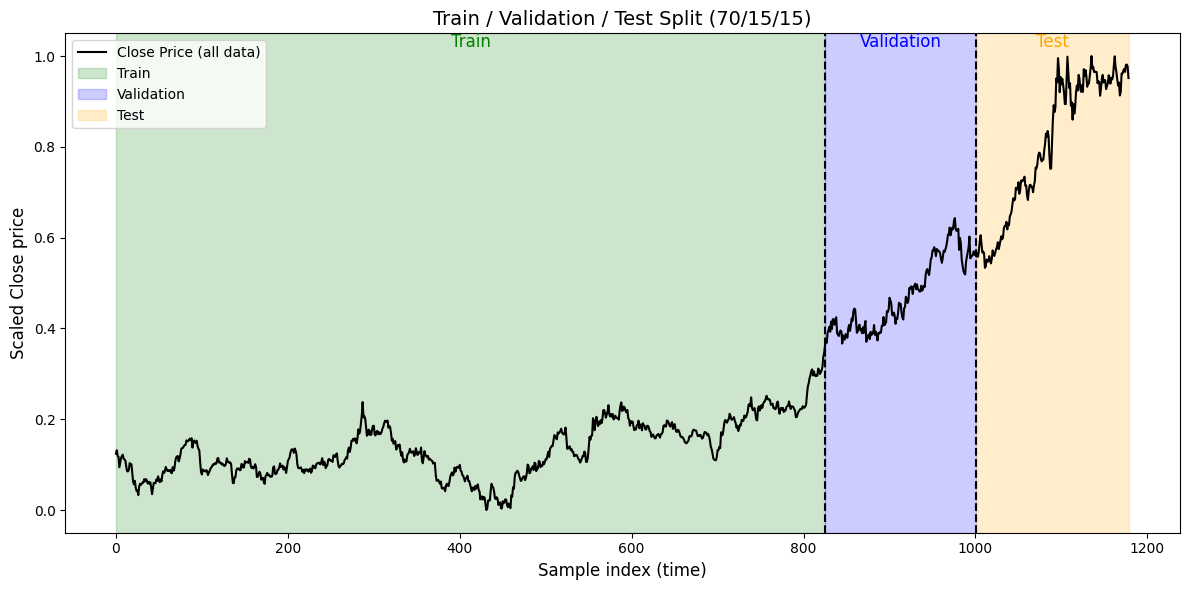

In [29]:
# Step 9 – Visualize Train/Validation/Test Split (Enhanced)
import matplotlib.pyplot as plt
import numpy as np

# Plot the Close price over the full dataset
plt.figure(figsize=(12,6))
plt.plot(y, label="Close Price (all data)", color="black")

# Mark train/val/test regions with shading
train_end = len(y_train)
val_end = train_end + len(y_val)

plt.axvspan(0, train_end, color="green", alpha=0.2, label="Train")
plt.axvspan(train_end, val_end, color="blue", alpha=0.2, label="Validation")
plt.axvspan(val_end, len(y), color="orange", alpha=0.2, label="Test")

# Add vertical boundary lines
plt.axvline(train_end, color="black", linestyle="--")
plt.axvline(val_end, color="black", linestyle="--")

# Add text labels above each section
plt.text(train_end/2, 1.02, "Train", ha="center", color="green", fontsize=12)
plt.text((train_end+val_end)/2, 1.02, "Validation", ha="center", color="blue", fontsize=12)
plt.text((val_end+len(y))/2, 1.02, "Test", ha="center", color="orange", fontsize=12)

# Titles and labels
plt.title("Train / Validation / Test Split (70/15/15)", fontsize=14)
plt.xlabel("Sample index (time)", fontsize=12)
plt.ylabel("Scaled Close price", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


**Step 10 – Build TCN Model**

In [30]:
# Step 10 – Build TCN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tcn import TCN

model = Sequential([
    TCN(input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn_1 (TCN)                     │ (None, 64)             │       137,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,345 (536.50 KB)

 Trainable params: 137,345 (536.50 KB)

 Non-trainable params: 0 (0.00 B)

**Step 11 – Train Model (with callbacks)**

In [31]:
# Step 11 – Train Model (with callbacks)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
]

history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 5.4147 - val_loss: 0.0507 - learning_rate: 0.0010
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0273 - val_loss: 0.0647 - learning_rate: 0.0010
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0076 - val_loss: 0.0117 - learning_rate: 0.0010
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0044 - val_loss: 0.0123 - learning_rate: 0.0010
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0028 - val_loss: 0.0101 - learning_rate: 0.0010
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0021 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0018 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0014 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0012 - val_loss: 0.0121 - learning_rate: 5.0000e-04
Epoch 10/50
26/

**Step 12 – Predict**

In [32]:
# Step 12 – Predict
y_pred = model.predict(X_test)


1/6 ━━━━━━━━━━━━━━━━━━━━ 2s 426ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step


**Step 13 – Evaluate**

In [33]:
# Step 13 – Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / (np.abs(y_test) + 1e-8))) * 100

print(f"RMSE: {rmse:.5f}")
print(f"MAE: {mae:.5f}")
print(f"MAPE: {mape:.2f}%")


RMSE: 0.27746
MAE: 0.23096
MAPE: 43.42%


**Step 14 – Inverse Transform (Back to USD)**

In [34]:
def inverse_transform(value_column):
    dummy = np.zeros((len(value_column), len(features)))
    dummy[:, features.index(target)] = value_column.reshape(-1)
    return scaler.inverse_transform(dummy)[:, features.index(target)]

actual = inverse_transform(y_test)
predicted = inverse_transform(y_pred)


**Step 15 – Plot Results**

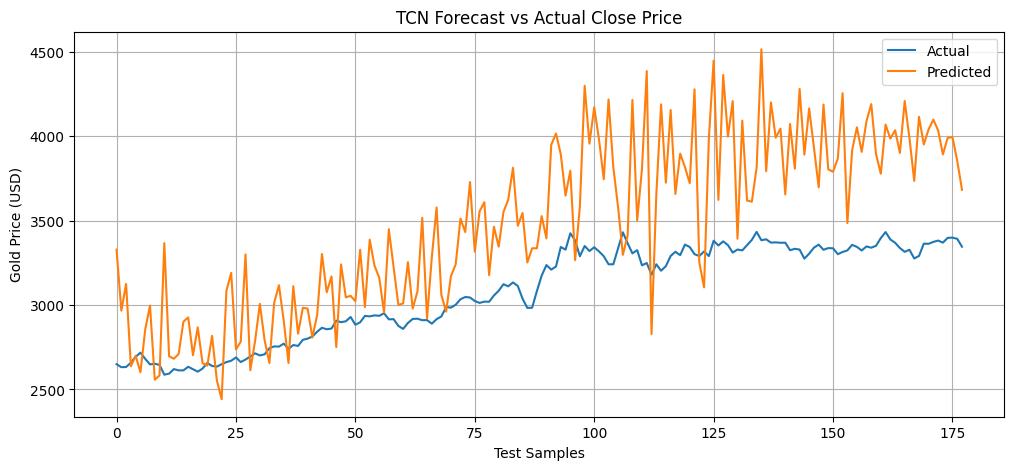

In [35]:
# Step 15 – Plot Results
plt.figure(figsize=(12,5))
plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.title('TCN Forecast vs Actual Close Price')
plt.xlabel('Test Samples')
plt.ylabel('Gold Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


**Step 16 – Export Results + Save Model**

In [36]:
# STEP 16 – Export Results + Save Model (.keras + .joblib)
from tcn import TCN
from joblib import dump, load
import os
import pandas as pd

# ==============================
# 1️⃣ Prepare results DataFrame
# ==============================
test_start_idx = sequence_length + len(X_train) + len(X_val)
test_dates = df['Date'].iloc[test_start_idx:].reset_index(drop=True)

output_df = pd.DataFrame({
    'Date': test_dates,
    'Actual_Close_USD': actual.ravel(),
    'Predicted_Close_USD': predicted.ravel()
})

# Save prediction results
output_name = "tcn_v1_baseline_output.csv"
output_path = os.path.join(MODELS, output_name)
output_df.to_csv(output_path, index=False)
print(f"✅ Results saved to {output_path}")

# ==============================
# 2️⃣ Save model in both formats
# ==============================
# Save as .keras (TensorFlow native format)
model_name = "tcn_v1_baseline.keras"
keras_path = os.path.join(MODELS, model_name)
model.save(keras_path)
print(f"✅ Model saved as {keras_path}")

# Save as .joblib (for later comparison or reloading)
joblib_name = "tcn_v1_baseline.joblib"
joblib_path = os.path.join(MODELS, joblib_name)
dump(model, joblib_path)
print(f"✅ Model also saved as {joblib_path}")

# ==============================
# 3️⃣ (Optional) Verify .joblib file
# ==============================
loaded_model = load(joblib_path)
print("✅ .joblib model loaded successfully")

# Test one prediction for confirmation
test_pred = loaded_model.predict(X_test[:5])
print("🔍 Sample predictions from loaded model:", test_pred.flatten()[:5])


✅ Results saved to /content/drive/My Drive/GoldForecasting_Project (ISY5002)/Models/TCN/tcn_v1_baseline_output.csv
✅ Model saved as /content/drive/My Drive/GoldForecasting_Project (ISY5002)/Models/TCN/tcn_v1_baseline.keras
✅ Model also saved as /content/drive/My Drive/GoldForecasting_Project (ISY5002)/Models/TCN/tcn_v1_baseline.joblib
✅ .joblib model loaded successfully


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
🔍 Sample predictions from loaded model: [0.94216466 0.74281317 0.82989234 0.56084794 0.59522057]


**Step 17 – Directional Accuracy & Confusion Matrix**

Directional Accuracy: 55.37%


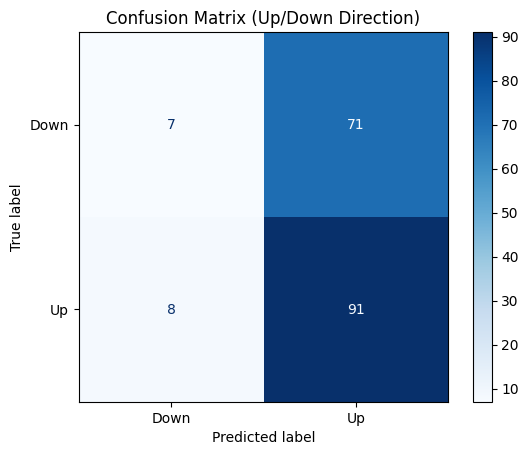

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Convert actual and predicted to binary (Up = 1, Down = 0)
actual_direction = (actual[1:] > actual[:-1]).astype(int)
predicted_direction = (predicted[1:] > actual[:-1]).astype(int)

# Accuracy
acc = accuracy_score(actual_direction, predicted_direction)
print(f"Directional Accuracy: {acc:.2%}")

# Confusion matrix
cm = confusion_matrix(actual_direction, predicted_direction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down","Up"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Up/Down Direction)")
plt.show()


In [38]:
# STEP 18 - Download Model, Predictions & Requirements (optional)
from google.colab import files
import os

# Download TCN_v1 model (.keras)
files.download(os.path.join(MODELS, "tcn_v1_baseline.keras"))

# Download TCN_v1 predictions (.csv)
files.download(os.path.join(MODELS, "tcn_v1_baseline_output.csv"))

# Download TCN_v1 model (.joblib)
files.download(os.path.join(MODELS, "tcn_v1_baseline.joblib"))

# --- NEW SECTION: Save environment requirements ---
# Generate requirements file for reproducibility
!pip freeze > "{os.path.join(MODELS, 'requirements_tcn_v1_baseline.txt')}"

# Download requirements file
files.download(os.path.join(MODELS, "requirements_tcn_v1_baseline.txt"))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>